<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras



### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

---

### Introducción
Utilizo el libro **Harry Potter y La piedra filosofal**, de la autora J.K. Rowling para entrenar el modelo, de manera tal que la predicción de la palabra va a estar relacionada con el contexto de la historia dada en el libro.

#### Importación de librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing

import random
import io
import pickle

import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

import gradio as gr

### Preparación del Dataset

Utilizo como dataset el libro de Harry Potter de la autora J.K. Rowling.

In [3]:
# Armo el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('Book1.txt', sep='/n', header=None, engine='python')
df.head(10)

,0
0,/
1,THE BOY WHO LIVED
2,"Mr. and Mrs. Dursley, of number four, Privet D..."
3,were proud to say that they were perfectly nor...
4,thank you very much. They were the last people...
5,expect to be involved in anything strange or
6,"mysterious, because they just didn’t hold with..."
7,nonsense.
8,Mr. Dursley was the director of a firm called
9,"Grunnings, which made drills. He was a big, beefy"


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 10144


In [5]:
# Veo las primeras filas del dataset
df.loc[:15,0]

0                                                     /
1                                     THE BOY WHO LIVED
2     Mr. and Mrs. Dursley, of number four, Privet D...
3     were proud to say that they were perfectly nor...
4     thank you very much. They were the last people...
5          expect to be involved in anything strange or
6     mysterious, because they just didn’t hold with...
7                                             nonsense.
8         Mr. Dursley was the director of a firm called
9     Grunnings, which made drills. He was a big, beefy
10     man with hardly any neck, although he did have a
11       very large mustache. Mrs. Dursley was thin and
12      blonde and had nearly twice the usual amount of
13      neck, which came in very useful as she spent so
14    much of her time craning over garden fences, s...
15      on the neighbors. The Dursley s had a small son
Name: 0, dtype: object

#### Armado de corpus

In [6]:
# Concateno cada fila para obtener el corpus de texto
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'/ THE BOY WHO LIVED Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense. Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursley s had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn’t think they could bear it if anyone found out about the Potters. Mrs. Potter was Mrs. Dursley’s sister, but they hadn’t

In [7]:
# Muestro las primeras 500 caracteres del texto concatenado para verificar
print(corpus[:500])

/ THE BOY WHO LIVED Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense. Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twi


#### Segmentación del corpus en oraciones utilizando NLTK

Utilicé NLTK para segmentar el corpus en oraciones debido a su precisión y robustez en el procesamiento de lenguaje natural. NLTK incluye un segmentador de oraciones que maneja de manera eficiente los diferentes patrones de puntuación y las abreviaturas comunes en inglés, asegurando una correcta segmentación del texto.

In [8]:
# Voy a utilizar NLTK para poder separar las oraciones
import nltk
import os

nltk_data_path = 'nltk_data'
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

# configuro NLTK para usar el nuevo directorio
nltk.data.path.append(os.path.abspath(nltk_data_path))

nltk.download('punkt_tab', download_dir=nltk_data_path)

print(nltk.data.path)
try:
    print(nltk.data.find('tokenizers/punkt_tab'))
except LookupError:
    print("El recurso 'punkt_tab' no está disponible. Verifica la instalación.")

['/Users/diegosarina/nltk_data', '/Users/diegosarina/Development/personal/diegosarina-ceia_publico/nlp/.venv/nltk_data', '/Users/diegosarina/Development/personal/diegosarina-ceia_publico/nlp/.venv/share/nltk_data', '/Users/diegosarina/Development/personal/diegosarina-ceia_publico/nlp/.venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/Users/diegosarina/Development/personal/diegosarina-ceia_publico/nlp/DESAFIO_3/nltk_data']
/Users/diegosarina/Development/personal/diegosarina-ceia_publico/nlp/DESAFIO_3/nltk_data/tokenizers/punkt_tab


[nltk_data] Downloading package punkt_tab to nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [9]:
# Segmento el corpus en sentencias (oraciones) haciendo uso de NLTK
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(corpus)

In [10]:
# Visualizo la segmentacion
print(f"longitud: {len(sentences)}")
print(f"Oracion: {sentences[0]}")

longitud: 5066
Oracion: / THE BOY WHO LIVED Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much.


#### Preprocesamiento de datos

- Hay que transformar las oraciones en tokens.
- A las oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Se tiene que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

##### Segmentación de las oraciones en tokens de sentencias

In [11]:
# segmentamos el texto con la utilidad de Keras
sentence_tokens = [text_to_word_sequence(sentence) for sentence in sentences]

In [12]:
print("Cantidad de tokens en el corpus:", len(sentence_tokens))

Cantidad de tokens en el corpus: 5066


In [13]:
# Hago una visualizacion
print(f"Frase original: {sentences[0]}")
print(f"Frase segmentada: {sentence_tokens[0]}")

# Vistazo general
print(f"Vistazo general: {sentence_tokens[0:2]}")


Frase original: / THE BOY WHO LIVED Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much.
Frase segmentada: ['the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much']
Vistazo general: [['the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much'], ['they', 'were', 'the', 'last', 'people', 'you’d', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn’t', 'hold', 'with', 'such', 'nonsense']]


##### Calculo de longitud de sentencias

In [14]:
# calculamos la longitud de cada secuencia y grafico la distribucion de las mismas
sentence_lengths = [len(sentence) for sentence in sentence_tokens]

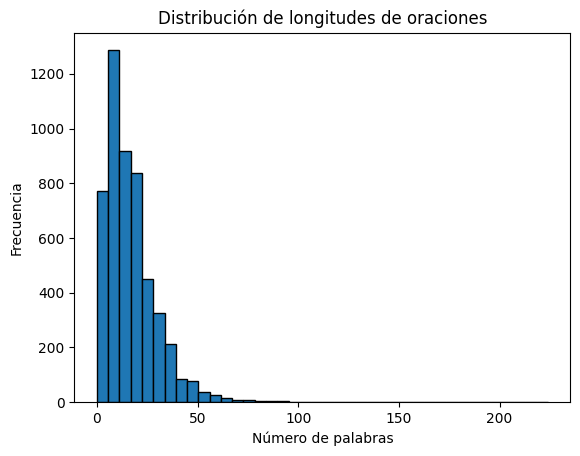

In [15]:
# Visualizar la distribución
plt.hist(sentence_lengths, bins=40, edgecolor='black')
plt.title('Distribución de longitudes de oraciones')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()

In [16]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto.

max_context_size = int(np.percentile(sentence_lengths, 90)-1)

#esto selecciona el valor en el percentil 90 de la distribución de longitudes de las secuencias.
#el -1 se utiliza porque el último token se reservará como el objetivo para predicción,
#por lo tanto, se reduce en 1 el tamaño del contexto.

print(f"max_context_size basado en el percentil 90: {max_context_size}")


max_context_size basado en el percentil 90: 32


Del paso anterior, vemos que el `max_context_size` da como resultado 32. Sin embargo, esto reduce drasticamente a futuro la cantidad de tokens para poder alargar el mismo. Por ello voy a hacer uso de un valor cercado a la mediana. La misma actualmente si la computamos nos da un valor de 14.

Yo en mi ejemplo hare uso de un valor ligeramente superior `16` que represneta el percentil 60.

In [17]:
# Aclarado lo anterior:
max_context_size = 16


#### Tokenización

In [18]:
# instanciamos el tokenizador de Keras
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto y se aplica N veces para preprocesar datos.
# El token 0 está reservado para palabras fuera del vocabulario

tok.fit_on_texts(sentence_tokens)

# Convertimos las palabras a números (tokenización).
# entran palabras -> Salidas: secuencias de números (tokens)
tokenized_sentences = tok.texts_to_sequences(sentence_tokens)

# verifico los resultados de tokenización en la primera oración
print(sentence_tokens[0])
print(tokenized_sentences[0])

['the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much']
[1, 147, 70, 1089, 153, 3, 278, 225, 8, 656, 336, 657, 538, 41, 1268, 4, 169, 20, 19, 41, 1591, 974, 1592, 14, 76, 160]


#### Estructaración del dataset para entrenamiento

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [19]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, sentence_tokens, test_size=0.2, random_state=42)

In [20]:
print(f"Tamaño del dataset de train: {len(tokenized_sentences_train)}")
print(f"Tamaño del dataset de test: {len(tokenized_sentences_val)}")

Tamaño del dataset de train: 4052
Tamaño del dataset de test: 1014


Vamos a dividir las oraciones que tienen más tokens que el contexto máximo, generando más secuencias. Esto aumenta la cantidad de datos disponibles para entrenar el modelo.

In [21]:
tok_sent = []

for sent in tokenized_sentences_train:
  # Si la secuencia es mayor al tamaño de contexto máximo, generamos subsecuencias.
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    # Generamos varias subsecuencias de tamaño máximo
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else:
    # Si la secuencia es menor o igual al contexto máximo, la usamos tal cual.
    tok_sent.append(sent)

In [22]:
len(tok_sent)

22713

Ademas vemos que al haber utilizado un `max_context_size` menor, se permitio dividir aun mas y generar mas tokens lo que represneta mas información disponible en simples rasgos.

In [23]:
tok_sent_augm = []

for sent in tok_sent:
  # Generamos todas las sub-secuencias posibles a partir de la secuencia original
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # paddeamos (rellenamos) las secuencias para que tengan el tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [24]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [25]:
train_seqs.shape

(343850, 17)

In [26]:
# separamos las entradas (X) y los objetivos (y) que consumirá el modelo durante el entrenamiento
X = train_seqs[:,:-1] # entradas (contexto)
y = train_seqs[:,1:] # salidas

In [27]:
# visualizamos el vocabulario
print(f"Palabras en el vocabulario: {tok.index_word}")

# calculamos la cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts) 
print(f"Tamaño del vocabulario: {vocab_size}")

# indice de cada palabra, ordenado de las más frecuentes a las menos frecuentes
print(f"Índice de palabras: {tok.word_index}")

# cantidad de veces que cada palabra aparece en los documentos
print(f"Frecuencia de palabras en documentos: {tok.word_docs}")

# cantidad de secuencias generadas en el dataset de entrenamiento
print(f"Cantidad de secuencias en el dataset: {X.shape[0]}")


Palabras en el vocabulario: {1: 'the', 2: '”', 3: 'and', 4: 'to', 5: 'a', 6: 'harry', 7: 'he', 8: 'of', 9: 'was', 10: 'it', 11: 'in', 12: 'his', 13: '—', 14: 'you', 15: 'said', 16: 'had', 17: 'on', 18: 'at', 19: 'they', 20: 'that', 21: 'as', 22: 'him', 23: 'i', 24: 'potter', 25: 'but', 26: 'stone', 27: 'with', 28: 'ron', 29: 'all', 30: 'out', 31: 'up', 32: 'for', 33: 'be', 34: 'k', 35: 'page', 36: 'philosophers', 37: 'j', 38: 'rowling', 39: 'hagrid', 40: 'them', 41: 'were', 42: 'have', 43: 'what', 44: 'there', 45: 'back', 46: 'hermione', 47: 'one', 48: 'from', 49: 'this', 50: 'not', 51: 'if', 52: 'she', 53: 'about', 54: 'into', 55: 'their', 56: 'me', 57: 'know', 58: 'been', 59: 'so', 60: 'off', 61: 'didn’t', 62: 'could', 63: 'like', 64: 'got', 65: 'get', 66: 'down', 67: '“i', 68: 'her', 69: 'when', 70: 'who', 71: 'over', 72: 'looked', 73: 'professor', 74: 'see', 75: 'just', 76: 'very', 77: 'is', 78: 'then', 79: 'no', 80: 'do', 81: 'by', 82: 'your', 83: 'snape', 84: 'are', 85: 'now', 86

### Definición de los Modelos a entrenar

A continuación se presentarán una serie de arquitecturas que serán entrenadas. Luego, se incluirá una captura de la predicción realizada con Gradio. Finalmente, se documentará la generación de secuencias y la implementación de beam search para cada modelo.

#### Definición de funciones a utilizar por cada bloque de entrenamiento

In [28]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5, model_name='best_model'):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):
        scores = []
        batch_size = 32

        for start_idx, (start, end) in enumerate(self.info):

            batch_padded = self.padded[start:end]
            num_batches = int(np.ceil(len(batch_padded) / batch_size))

            probs = []
            for i in range(num_batches):
                batch_start = i * batch_size
                batch_end = min((i + 1) * batch_size, len(batch_padded))
                batch_predictions = self.model.predict(batch_padded[batch_start:batch_end], verbose=0)

                for idx_seq, idx_vocab in zip(range(batch_start, batch_end), self.target[start:end]):
                    probs.append(batch_predictions[idx_seq - batch_start, -1, idx_vocab])

            scores.append(np.exp(-np.sum(np.log(probs)) / (end - start)))

            del batch_padded, batch_predictions, probs

        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save(f'{self.model_name}.keras')
            print(f"Saved new model: {self.model_name}.keras")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Stopping training...")
                self.model.stop_training = True

In [29]:
# Generacion de secuencias
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text

    index_word = {index: word for word, index in tokenizer.word_index.items()}

	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded, verbose=0)[0,-1,:])

      # Vamos concatenando las predicciones
      # out_word = ''
      out_word = index_word.get(y_hat, '')

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      #for word, index in tokenizer.word_index.items():
      #  if index == y_hat:
      #    out_word = word
      #    break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [30]:
# Beam Search y Muestreo aleatorio

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])


from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [31]:
import gradio as gr

def model_response(human_text, model_to_load):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model_to_load.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

In [32]:
def test_model_gradio(model):
    iface = gr.Interface(
        fn=lambda human_text: model_response(human_text, model),
        inputs=["textbox"],
        outputs="text",
        )

    return iface.launch(debug=True)

#### Modelo 0 - LSTM base

##### Definición del modelo

In [35]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=128, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/Users/diegosarina/Development/personal/diegosarina-ceia_publico/nlp/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 128)      │       868,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 100)      │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 6784)     │       685,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,725,536 (6.58 MB)

 Trainable params: 1,725,536 (6.58 MB)

 Non-trainable params: 0 (0.00 B)

##### Entrenamiento del modelo

In [36]:
history_ppl_0 = []
history_model_0 = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_0, model_name='model0')], batch_size=64)

Epoch 1/20


2024-09-20 20:11:53.298255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9921
 mean perplexity: 1504.6177753557781 

Saved new model: model0.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 146s 26ms/step - loss: 3.9920
Epoch 2/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.2437
 mean perplexity: 1252.7244094695839 

Saved new model: model0.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 137s 26ms/step - loss: 3.2437
Epoch 3/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.9512
 mean perplexity: 1366.45007146167 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 137s 26ms/step - loss: 2.9512
Epoch 4/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.7319
 mean perplexity: 1422.9874855433577 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - loss: 2.7318
Epoch 5/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.5547
 mean perplexity: 1664.313036643712 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 143s 27ms/step - loss: 2.5547
Epoch 6/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.3889
 mean perplexity: 1992.15193980801

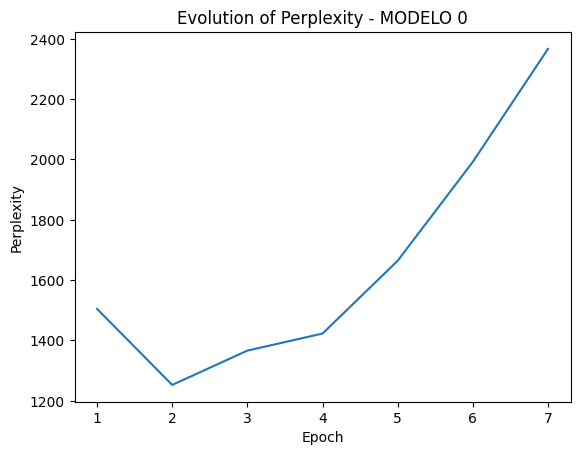

In [42]:
# Grafico de la evolución de la perplejidad
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.

import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl_0) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_0)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Evolution of Perplexity - MODELO 0')
plt.show()

In [43]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('model0.keras')

##### Prueba con interfaz gráfica gradio (predicción próxima palabra)

In [44]:
test_model_gradio(model=model)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Keyboard interruption in main thread... closing server.


##### Generacion de secuencias

In [50]:
input_text = 'Harry, Ron and Hermione have been friends'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=5)

'Harry, Ron and Hermione have been friends and he was a lot'

##### Beam Search

In [53]:
input_text = 'Harry, Ron and Hermione have been friends' # Frase inicial
num_beams = 3  # Número de secuencias
num_words = 10  # Número de palabras a generar
temp = 1  # Temperatura (1 es determinista)
mode = 'det'  # Modo de selección (determinista)

tokens_generados = beam_search(model, num_beams, num_words, input_text, temp=temp, mode=mode)
# Decodificar los tokens a texto
for seq in tokens_generados:
    texto_generado = decode(seq)
    print("Generated sequence:", texto_generado)

Generated sequence: ['harry ron and hermione have been friends and he was a lot of a lot of a']
Generated sequence: ['harry ron and hermione have been friends and he was a lot of a lot of the']
Generated sequence: ['harry ron and hermione have been friends and he was a lot of a lot of his']


#### Modelo 1: SimpleRNN con Dropout

##### Definición del modelo

In [54]:
from tensorflow.keras.layers import SimpleRNN

model1 = Sequential()

# Embedding entrenable con mayor dimensión de salida
model1.add(Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=(None,)))

# Dos capas SimpleRNN con Dropout para evitar sobreajuste
model1.add(SimpleRNN(128, return_sequences=True))
model1.add(Dropout(0.3))
model1.add(SimpleRNN(128, return_sequences=True))
model1.add(Dropout(0.3))

# Predicción de clasificación con softmax
model1.add(Dense(vocab_size+1, activation='softmax'))

# Compilación del modelo
model1.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model1.summary()

/Users/diegosarina/Development/personal/diegosarina-ceia_publico/nlp/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 64)       │       434,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 6784)     │       875,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,912 (5.21 MB)

 Trainable params: 1,366,912 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

##### Entrenamiento del modelo

In [55]:
history_ppl_1 = []
history_model4 = model1.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_1, model_name='model_1')], batch_size=64)

Epoch 1/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 3.7222
 mean perplexity: 1412.3464556954134 

Saved new model: model_1.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 1655s 308ms/step - loss: 3.7221
Epoch 2/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 2.8232
 mean perplexity: 1520.9211907707422 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 1572s 292ms/step - loss: 2.8232
Epoch 3/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 2.5034
 mean perplexity: 1800.6179313702878 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 1574s 293ms/step - loss: 2.5034
Epoch 4/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 2.2861
 mean perplexity: 2077.5822393641715 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 1573s 293ms/step - loss: 2.2861
Epoch 5/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 2.1339
 mean perplexity: 2418.2178426805604 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 1548s 288ms/step - loss: 2.1339
Epoch 6/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 2.0232
 mean perplexity: 2479.3594171714

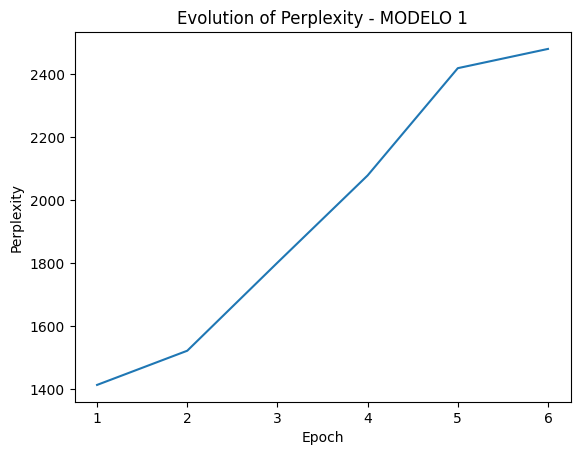

In [56]:
# Grafico de la evolución de la perplejidad
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.

import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl_1) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_1)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Evolution of Perplexity - MODELO 1')
plt.show()

In [57]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model1 = keras.models.load_model('model_1.keras')

##### Prueba con interfaz gráfica gradio (predicción próxima palabra)

In [58]:
test_model_gradio(model=model1)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Keyboard interruption in main thread... closing server.


A continuación dejo una imagen de muestra del experimiento con gradio

<img src="./imagenes_pruebas_gradio/modelo_1/img1.png">


##### Generacion de secuencias

In [59]:
input_text = 'Harry, Ron and Hermione have been friends'

generate_seq(model1, tok, input_text, max_length=max_context_size, n_words=5)

'Harry, Ron and Hermione have been friends to get a lot of'

##### Beam search

In [60]:
input_text = 'Harry, Ron and Hermione have been friends' # Frase inicial
num_beams = 3  # Número de secuencias
num_words = 10  # Número de palabras a generar
temp = 1  # Temperatura (1 es determinista)
mode = 'det'  # Modo de selección (determinista)

tokens_generados = beam_search(model1, num_beams, num_words, input_text, temp=temp, mode=mode)
# Decodificar los tokens a texto
for seq in tokens_generados:
    texto_generado = decode(seq)
    print("Generated sequence:", texto_generado)

Generated sequence: ['harry ron and hermione have been friends to get him in the house ” said harry potter']
Generated sequence: ['harry ron and hermione have been friends to get him in the house ” harry and ron']
Generated sequence: ['harry ron and hermione have been friends to get him in the house ” said harry his']


#### Modelo 2 - LSTM con dropout

##### Definicion del modelo

In [65]:
model2 = Sequential()

# Embedding con menor dimensión de salida
model2.add(Embedding(input_dim=vocab_size+1, output_dim=32, input_shape=(None,)))

# Capas LSTM con Dropout para evitar sobreajuste
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))

# Predicción con softmax
model2.add(Dense(vocab_size+1, activation='softmax'))

# Compilación del modelo
model2.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, None, 32)       │       217,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, None, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 6784)     │       440,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 715,904 (2.73 MB)

 Trainable params: 715,904 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

##### Entrenamiento del modelo

In [66]:
history_ppl_2 = []
history_model_2 = model2.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_2, model_name='model_2')], batch_size=64)

Epoch 1/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.2523
 mean perplexity: 1668.6321261563648 

Saved new model: model_2.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 118s 22ms/step - loss: 4.2522
Epoch 2/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.5210
 mean perplexity: 1347.7736503928152 

Saved new model: model_2.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 116s 22ms/step - loss: 3.5210
Epoch 3/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3394
 mean perplexity: 1208.8063237072968 

Saved new model: model_2.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 117s 22ms/step - loss: 3.3394
Epoch 4/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1744
 mean perplexity: 1394.5598298255395 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 117s 22ms/step - loss: 3.1744
Epoch 5/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0476
 mean perplexity: 1265.9082072865053 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 117s 22ms/step - loss: 3.0476
Epoch 6/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - 

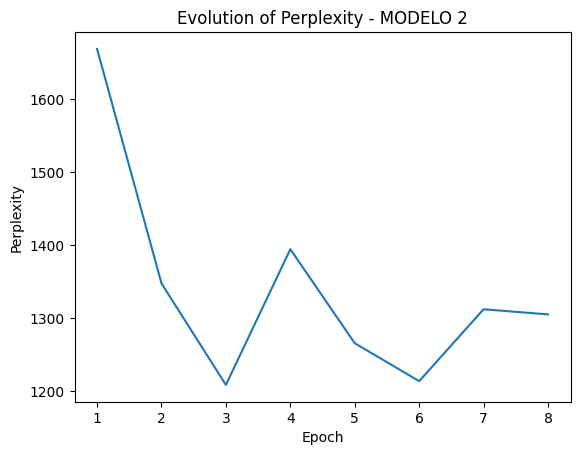

In [67]:
# Grafico de la evolución de la perplejidad
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.

import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl_2) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_2)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Evolution of Perplexity - MODELO 2')
plt.show()

In [68]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model2 = keras.models.load_model('model_2.keras')

##### Prueba con interfaz gráfica gradio (predicción próxima palabra)

In [72]:
test_model_gradio(model=model2)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Keyboard interruption in main thread... closing server.


A continuación dejo una imagen de muestra del experimiento con gradio

<img src="./imagenes_pruebas_gradio/modelo_2/img1.png">


##### Generacion de secuencias

In [69]:
input_text = 'Harry, Ron and Hermione have been friends'

generate_seq(model2, tok, input_text, max_length=max_context_size, n_words=5)

'Harry, Ron and Hermione have been friends ” he was going to'

##### Beam search

In [70]:
input_text = 'Harry, Ron and Hermione have been friends'  # Frase inicial
num_beams = 3  # Número de secuencias
num_words = 10  # Número de palabras a generar
temp = 1  # Temperatura (1 es determinista)
mode = 'det'  # Modo de selección (determinista)

tokens_generados = beam_search(model2, num_beams, num_words, input_text, temp=temp, mode=mode)
# Decodificar los tokens a texto
for seq in tokens_generados:
    texto_generado = decode(seq)
    print("Generated sequence:", texto_generado)

Generated sequence: ['harry ron and hermione have been friends ” he was going to be to be to be']
Generated sequence: ['harry ron and hermione have been friends ” he was going to get him to be to']
Generated sequence: ['harry ron and hermione have been friends ” he was going to be to be to have']


#### Modelo 3 - GRU

##### Definicion del modelo

In [75]:
from tensorflow.keras.layers import GRU

model3 = Sequential()

# Embedding entrenable con tamaño de salida intermedio
model3.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

# GRU con Dropout
model3.add(GRU(100, return_sequences=True))
model3.add(Dropout(0.2))

# Predicción con softmax
model3.add(Dense(vocab_size+1, activation='softmax'))

# Compilación del modelo
model3.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model3.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, None, 50)       │       339,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, None, 100)      │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, None, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, None, 6784)     │       685,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,984 (4.08 MB)

 Trainable params: 1,069,984 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

##### Entrenamiento del modelo

In [76]:
history_ppl_3 = []
history_model_3 = model3.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_3, model_name='model_3')], batch_size=64)

Epoch 1/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.9269
 mean perplexity: 1575.1985655034046 

Saved new model: model_3.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 123s 23ms/step - loss: 3.9268
Epoch 2/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2628
 mean perplexity: 2308.511727651208 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 107s 20ms/step - loss: 3.2628
Epoch 3/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0602
 mean perplexity: 1472.5805890033869 

Saved new model: model_3.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 3.0602
Epoch 4/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9601
 mean perplexity: 1278.0882371969553 

Saved new model: model_3.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 2.9601
Epoch 5/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8671
 mean perplexity: 1724.7589329726814 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 2.8671
Epoch 6/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - l

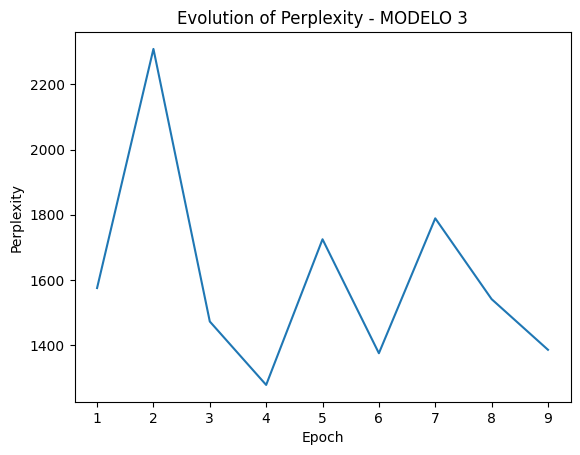

In [77]:
# Grafico de la evolución de la perplejidad
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.

import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl_3) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_3)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Evolution of Perplexity - MODELO 3')
plt.show()

In [78]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model3 = keras.models.load_model('model_3.keras')

##### Prueba con interfaz gráfica gradio (predicción próxima palabra)

In [79]:
test_model_gradio(model=model3)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Keyboard interruption in main thread... closing server.


A continuación dejo una imagen de muestra del experimento con gradio

<img src="./imagenes_pruebas_gradio/modelo_3/img2.png">


##### Generacion de secuencias

In [80]:
input_text = 'Harry, Ron and Hermione have been friends'

generate_seq(model3, tok, input_text, max_length=max_context_size, n_words=5)

'Harry, Ron and Hermione have been friends of the dark arts the'

##### Beam search

In [81]:
input_text = 'Harry, Ron and Hermione have been friends' # Frase inicial
num_beams = 3  # Número de secuencias
num_words = 10  # Número de palabras a generar
temp = 1  # Temperatura (1 es determinista)
mode = 'det'  # Modo de selección (determinista)

tokens_generados = beam_search(model3, num_beams, num_words, input_text, temp=temp, mode=mode)
# Decodificar los tokens a texto
for seq in tokens_generados:
    texto_generado = decode(seq)
    print("Generated sequence:", texto_generado)

Generated sequence: ['harry ron and hermione have been friends of the air of the mirror of the door of']
Generated sequence: ['harry ron and hermione have been friends of the air of the air of the air of']
Generated sequence: ['harry ron and hermione have been friends of the air of the air of the air and']


#### Modelo 4 - Combinado

##### Definicion del modelo

In [82]:
model4 = Sequential()

# Embedding entrenable con mayor dimensión de salida
model4.add(Embedding(input_dim=vocab_size+1, output_dim=128, input_shape=(None,)))

# Primera capa LSTM, luego GRU
model4.add(LSTM(128, return_sequences=True))
model4.add(Dropout(0.3))
model4.add(GRU(128, return_sequences=True))
model4.add(Dropout(0.3))

# Predicción con softmax
model4.add(Dense(vocab_size+1, activation='softmax'))

# Compilación del modelo
model4.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model4.summary()

/Users/diegosarina/Development/personal/diegosarina-ceia_publico/nlp/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, None, 128)      │       868,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, None, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, None, 6784)     │       875,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,974,144 (7.53 MB)

 Trainable params: 1,974,144 (7.53 MB)

 Non-trainable params: 0 (0.00 B)

##### Entrenamiento del modelo

In [83]:
history_ppl_4 = []
history_model_4 = model4.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_4, model_name='model_4')], batch_size=64)

Epoch 1/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.9480
 mean perplexity: 1217.7440232341755 

Saved new model: model_4.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 139s 26ms/step - loss: 3.9479
Epoch 2/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.2095
 mean perplexity: 1067.2555451094263 

Saved new model: model_4.keras
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 126s 23ms/step - loss: 3.2095
Epoch 3/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.9540
 mean perplexity: 1077.7342512455002 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 129s 24ms/step - loss: 2.9539
Epoch 4/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7675
 mean perplexity: 1109.7991475390406 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 129s 24ms/step - loss: 2.7675
Epoch 5/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6148
 mean perplexity: 1159.1006693123627 

5373/5373 ━━━━━━━━━━━━━━━━━━━━ 129s 24ms/step - loss: 2.6148
Epoch 6/20
5373/5373 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4778
 mean perplexity: 

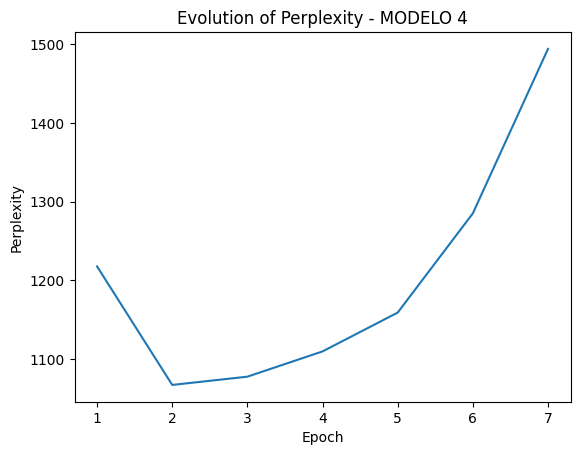

In [84]:
# Grafico de la evolución de la perplejidad
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.

import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl_4) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_4)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Evolution of Perplexity - MODELO 4')
plt.show()

In [85]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model4 = keras.models.load_model('model_4.keras')

##### Prueba con interfaz gráfica gradio (predicción próxima palabra)

In [86]:
test_model_gradio(model=model4)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Keyboard interruption in main thread... closing server.


A continuación dejo una imagen de muestra del experimento con gradio

<img src="./imagenes_pruebas_gradio/modelo_4/img1.png">


##### Generación de secuencias

In [87]:
input_text = 'Harry, Ron and Hermione have been friends'

generate_seq(model4, tok, input_text, max_length=max_context_size, n_words=5)

'Harry, Ron and Hermione have been friends of the school — ”'

##### Beam search

In [88]:
input_text = 'Harry, Ron and Hermione have been friends' # Frase inicial
num_beams = 3  # Número de secuencias
num_words = 10  # Número de palabras a generar
temp = 1  # Temperatura (1 es determinista)
mode = 'det'  # Modo de selección (determinista)

tokens_generados = beam_search(model4, num_beams, num_words, input_text, temp=temp, mode=mode)
# Decodificar los tokens a texto
for seq in tokens_generados:
    texto_generado = decode(seq)
    print("Generated sequence:", texto_generado)

Generated sequence: ['harry ron and hermione have been friends of the school — ” said harry potter and the']
Generated sequence: ['harry ron and hermione have been friends of the school — ” said harry potter and a']
Generated sequence: ['harry ron and hermione have been friends of the school — ” said harry potter and his']


### Conclusiones

Todos los modelos entrenados, utilizando `SimpleRNN`, `LSTM` y `GRU`, compartieron un comportamiento común en cuanto a la perplejidad. Al principio, la misma (primeras 2 épocas) se mantenía en valores de alrededor 1300 a 1500, pero luego comenzaba a incrementarse considerablemente, lo que provocaba la activación del early stopping. Este comportamiento sabe estar relacionado a:

- Calidad de los Datos: Datos de entrenamiento poco representativos o ruidosos.
- Problemas de Optimización: Parámetros de entrenamiento subóptimos.
- Arquitectura:
    - Tamaño del Embedding
    - Tamaño del Batch
    - Cantidad de capas
    - etc

En esencia el modelo al aumentar la perplejidad, nos indica que puede estar overfiteando lo que indica que el modelo no puede generalizar bien a los datos de validación.

Además, se realizaron pruebas utilizando una interfaz de Gradio para predecir la próxima palabra en una oración basada en el contexto del libro Harry Potter. Los resultados fueron consistentes: todos los modelos generaron palabras coherentes con el contexto, lo cual es un indicador positivo del aprendizaje del modelo en la tarea de predicción de texto. Algunos ejemplos de ellos fueron la predicción de:

- `j k`: próxima palabra predicha fue `rowling` (autora del libro)
- `harry`: próxima palabra predicha fue `potter` (apellido del personaje principal del libro)

Sin embargo, en la generación de secuencias más largas, la calidad y coherencia del texto disminuyó, haciendo en algunas ocasiones frases sin sentido.

Como resumen destaco los siguientes puntos:

1. Consumo de recursos: en este enfoque los entrenamientos tardaron alrededor de 1 hora a pesar de la GPU
2. Baja performance en la generación de secuencias largas: Aunque los modelos lograban predecir la próxima palabra de forma coherente, la generación de secuencias más largas tendía a producir resultados menos fluidos y coherentes
3. Uso de embeddings preentrenados: consideraria importante la implementación de embeddings preentrenados para futuras versiones del modelo. 

